<a href="https://colab.research.google.com/github/naokeyn/SIGNATE-J2024/blob/main/SIGNATE_J2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install lightgbm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [2]:
# Driveとの接続
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls "/content/drive/MyDrive/Colab Notebooks/SIGNATE/J2024"

holidays_in_japan.csv  sample_submit.csv  train.csv
match_reports.csv      test.csv		  venue_information.csv


In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score

import lightgbm as lgb
import optuna

In [84]:
data_path = "/content/drive/MyDrive/Colab Notebooks/SIGNATE/J2024"
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))

train_df.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40,NHK総合/J SPORTS(録),20916
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28,山梨放送/テレビ静岡(録)/J SPORTS(録),14277
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35,BS-i/MXテレビ(録)/J SPORTS(録),22531
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42,J SPORTS,28564
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),17199


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3672 non-null   int64  
 1   match_date     3672 non-null   object 
 2   kick_off_time  3672 non-null   object 
 3   section        3672 non-null   object 
 4   round          3672 non-null   object 
 5   home_team      3672 non-null   object 
 6   away_team      3672 non-null   object 
 7   venue          3672 non-null   object 
 8   weather        3672 non-null   object 
 9   temperature    3672 non-null   float64
 10  humidity       3672 non-null   int64  
 11  broadcasters   3672 non-null   object 
 12  attendance     3672 non-null   int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 373.1+ KB


# データの結合

## TVの放送数を追加
- NHKが放送するか
- 全国放送されるか

In [7]:
eda_df = train_df.copy()
eda_df["TVs"] = eda_df["broadcasters"].apply(lambda x: x.split("/"))
eda_df["num_TVs"] = eda_df["TVs"].apply(lambda x: len(x))
eda_df.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance,TVs,num_TVs
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40,NHK総合/J SPORTS(録),20916,"[NHK総合, J SPORTS(録)]",2
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28,山梨放送/テレビ静岡(録)/J SPORTS(録),14277,"[山梨放送, テレビ静岡(録), J SPORTS(録)]",3
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35,BS-i/MXテレビ(録)/J SPORTS(録),22531,"[BS-i, MXテレビ(録), J SPORTS(録)]",3
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42,J SPORTS,28564,[J SPORTS],1
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),17199,"[スカイパーフェクTV!, NHK名古屋(録), NHK大阪(録), J SPORTS(録)]",4


## スタジアムのキャパシティを追加
- 対戦相手の距離（都道府県情報）も追加出来たら

In [8]:
cap_df = pd.read_csv(os.path.join(data_path, "venue_information.csv"))
cap_df.head()

,venue,capacity,address
0,札幌ドーム,38794,北海道札幌市豊平区羊ヶ丘1
1,埼玉スタジアム2002,62010,埼玉県さいたま市緑区中野田500
2,味の素スタジアム,47851,東京都調布市西町376−3
3,町田GIONスタジアム,15320,東京都町田市野津田町2035
4,日産スタジアム,71624,神奈川県横浜市港北区小机町3300


In [9]:
eda_df = eda_df.merge(cap_df, on="venue", how="left")

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance,TVs,num_TVs,capacity,address
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40,NHK総合/J SPORTS(録),20916,"[NHK総合, J SPORTS(録)]",2,21000,大阪府吹田市千里万博公園5-2
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28,山梨放送/テレビ静岡(録)/J SPORTS(録),14277,"[山梨放送, テレビ静岡(録), J SPORTS(録)]",3,15859,山梨県甲府市小瀬町840
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35,BS-i/MXテレビ(録)/J SPORTS(録),22531,"[BS-i, MXテレビ(録), J SPORTS(録)]",3,47851,東京都調布市西町376−3
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42,J SPORTS,28564,[J SPORTS],1,51697,静岡県袋井市愛野2300−1
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),17199,"[スカイパーフェクTV!, NHK名古屋(録), NHK大阪(録), J SPORTS(録)]",4,20223,愛知県名古屋市瑞穂区山下通5-1


## 年月日，曜日を追加

In [42]:
eda_df["match_date"] = pd.to_datetime(eda_df["match_date"])
eda_df["year"] = eda_df["match_date"].dt.year
eda_df["month"] = eda_df["match_date"].dt.month
eda_df["day"] = eda_df["match_date"].dt.day
eda_df["weekday"] = eda_df["match_date"].dt.weekday

## 休日の情報を追加
- 土日も追加できるといいかも

In [38]:
holiday_df = pd.read_csv(os.path.join(data_path, "holidays_in_japan.csv"))
holidays = holiday_df["holiday_date"]

eda_df["is_holiday"] = eda_df["match_date"].isin(holidays)

In [40]:
# 土日祝日のカウント
uniq, counts = np.unique(eda_df["weekday"], return_counts=True)
print(dict(zip(uniq, counts)))

{0: 17, 1: 86, 2: 332, 3: 57, 4: 55, 5: 2342, 6: 783}


In [41]:
# 毎年何試合行っているか確認
uniq, counts = np.unique(eda_df["year"], return_counts=True)
print(dict(zip(uniq, counts)))

{2006: 306, 2007: 306, 2008: 306, 2009: 306, 2010: 306, 2011: 306, 2012: 306, 2013: 306, 2014: 306, 2015: 306, 2016: 306, 2017: 306}


## 選手情報，試合結果を追加
- 選手情報 &rarr; 背番号，ポジションだけにする？
- フォーメーションを追加？

In [11]:
pd.options.display.max_columns = None
report_df = pd.read_csv(os.path.join(data_path, "match_reports.csv"))
report_df.head()

,id,home_team_player11,home_team_player10,home_team_player9,home_team_player8,home_team_player7,home_team_player6,home_team_player5,home_team_player4,home_team_player3,home_team_player2,home_team_player1,home_team_score,away_team_score,away_team_player1,away_team_player2,away_team_player3,away_team_player4,away_team_player5,away_team_player6,away_team_player7,away_team_player8,away_team_player9,away_team_player10,away_team_player11
0,9190,9 マグノアウベス FW,8 フェルナンジーニョ FW,10 二川孝広 MF,7 遠藤保仁 MF,27 橋本英郎 MF,17 明神智和 MF,14 家長昭博 DF,6 山口智 DF,2 シジクレイ DF,21 加地亮 DF,22 藤ヶ谷陽介 GK,1,1,23 都築龍太 GK,2 坪井慶介 DF,4 田中マルクス闘莉王 DF,20 堀之内聖 DF,6 山田暢久 MF,17 長谷部誠 MF,13 鈴木啓太 MF,8 三都主アレサンドロ MF,18 小野伸二 MF,10 ポンテ FW,21 ワシントン FW
1,9191,18 長谷川太郎 FW,16 バレー FW,11 宇留野純 FW,31 林健太郎 MF,25 鈴木健太 MF,8 倉貫一毅 MF,4 山本英臣 DF,20 ビジュ DF,15 アライール DF,32 杉山新 DF,1 阿部謙作 GK,0,2,21 西部洋平 GK,25 市川大祐 DF,26 青山直晃 DF,4 高木和道 DF,3 山西尊裕 DF,13 兵働昭弘 MF,7 伊東輝悦 MF,16 枝村匠馬 MF,10 藤本淳吾 MF,18 チョジェジン FW,17 マルキーニョス FW
2,9192,9 ルーカス FW,21 サササルセード FW,35 リチェーリ FW,6 今野泰幸 MF,23 梶山陽平 MF,19 伊野波雅彦 MF,15 鈴木規郎 DF,5 増嶋竜也 DF,2 茂庭照幸 DF,25 徳永悠平 DF,1 土肥洋一 GK,2,0,1 西川周作 GK,2 三木隆司 DF,4 深谷友基 DF,22 上本大海 DF,5 エジミウソン MF,11 トゥーリオ MF,6 梅田高志 MF,17 根本裕一 MF,26 内村圭宏 MF,13 高松大樹 FW,9 オズマール FW
3,9193,15 西野泰正 FW,22 カレンロバート FW,7 名波浩 MF,14 村井慎二 MF,23 福西崇史 MF,25 ファブリシオ MF,11 西紀寛 MF,6 服部年宏 DF,5 田中誠 DF,2 鈴木秀人 DF,1 川口能活 GK,1,1,1 水谷雄一 GK,22 中村北斗 DF,4 金古聖司 DF,5 千代反田充 DF,3 アレックス DF,7 宮崎光平 MF,6 布部陽功 MF,8 ホベルト MF,14 古賀誠史 MF,27 田中佑昌 FW,36 グラウシオ FW
4,9194,19 杉本恵太 FW,11 玉田圭司 FW,27 片山奨典 MF,7 中村直志 MF,14 吉村圭司 MF,8 金正友 MF,6 有村光史 DF,29 深津康太 DF,5 古賀正紘 DF,4 大森征之 DF,22 川島永嗣 GK,3,2,22 吉田宗弘 GK,2 ブルーノクアドロス DF,5 前田和哉 DF,3 柳本啓成 DF,4 河村崇大 MF,23 下村東美 MF,10 ピンゴ MF,6 ゼカルロス MF,8 森島寛晃 FW,20 西澤明訓 FW,9 古橋達弥 FW


# EDA (探索的データ分析)

## 可視化

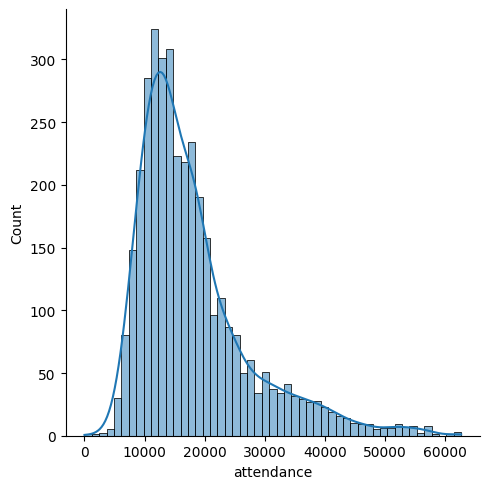

In [12]:
sns.displot(eda_df["attendance"], kde=True)

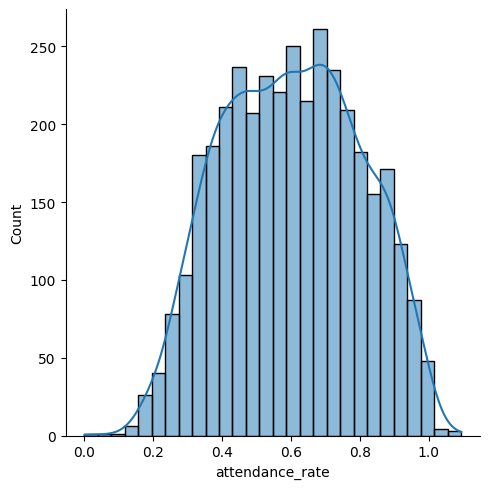

In [13]:
eda_df["attendance_rate"] = eda_df["attendance"] / eda_df["capacity"]
sns.displot(eda_df["attendance_rate"], kde=True)

<Axes: xlabel='attendance_rate', ylabel='Count'>

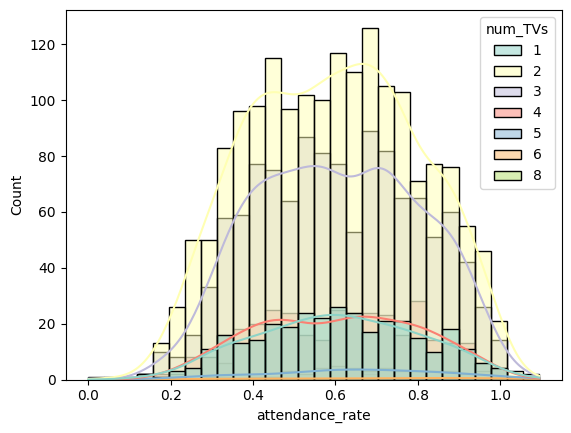

In [26]:
sns.histplot(eda_df, x="attendance_rate", hue="num_TVs", kde=True, palette="Set3")

<Axes: xlabel='attendance_rate', ylabel='Count'>

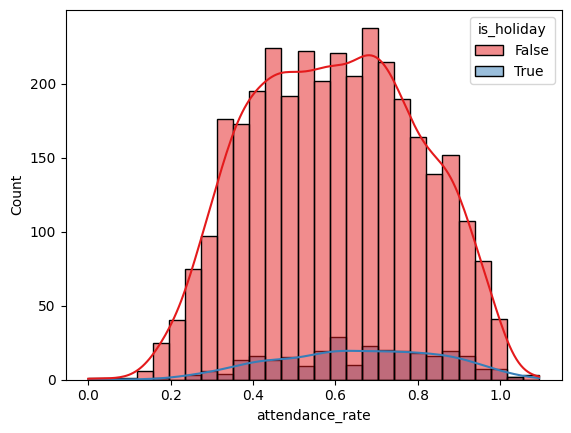

In [36]:
sns.histplot(eda_df, hue="is_holiday", x="attendance_rate", kde=True, palette="Set1")

# サンプルでモデル構築

In [107]:
cap_df = pd.read_csv(os.path.join(data_path, "venue_information.csv"))
holiday_df = pd.read_csv(os.path.join(data_path, "holidays_in_japan.csv"))
holidays = holiday_df["holiday_date"]

le_venue = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
le_team = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
le_weather = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

def build_datefeature(df) -> pd.DataFrame:
  df["match_date"] = pd.to_datetime(df["match_date"])
  df["year"] = df["match_date"].dt.year
  df["month"] = df["match_date"].dt.month
  df["day"] = df["match_date"].dt.day
  df["weekday"] = df["match_date"].dt.weekday
  return df

def build_holidayfeature(df) -> pd.DataFrame:
  df["is_holiday"] = df["match_date"].isin(holidays)
  return df

def build_tvfeature(df) -> pd.DataFrame:
  df["num_TVs"] = df["broadcasters"].apply(lambda x: len(x.split("/")))
  df = df.drop(["broadcasters"], axis=1)
  return df

def build_capfeature(df, train=True) -> pd.DataFrame:
  df = df.merge(cap_df[["venue", "capacity"]], on="venue", how="left")
  if train:
    df["attendance_rate"] = df["attendance"] / df["capacity"]
  return df

def build_kick_off_time_feature(df) -> pd.DataFrame:
  df["kick_off_time"] = pd.to_datetime(df["kick_off_time"])
  df["hour"] = df["kick_off_time"].dt.hour
  df["minute"] = df["kick_off_time"].dt.minute
  df = df.drop(["kick_off_time"], axis=1)
  return df

# def build_reportfeature(df) -> pd.DataFrame:
#   report_df = pd.read_csv(os.path.join(data_path, "match_reports.csv"))

def build_featureset(df, train=True) -> pd.DataFrame:
  df = build_datefeature(df)
  df = build_holidayfeature(df)
  df = build_tvfeature(df)
  df = build_capfeature(df, train=train)
  df = build_kick_off_time_feature(df)

  df["section"] = df["section"].str.extract("第([0-9]+)節").astype("int")
  df["round"] = df["round"].str.extract("第([0-9]+)日").astype("int")

  if train:
    df["venue"] = le_venue.fit_transform(df["venue"].to_numpy().reshape(-1, 1))
    df["home_team"] = le_team.fit_transform(df["home_team"].to_numpy().reshape(-1, 1))
    df["away_team"] = le_team.transform(df["away_team"].to_numpy().reshape(-1, 1))
    df["weather"] = le_weather.fit_transform(df["weather"].to_numpy().reshape(-1, 1))

  else:
    df["venue"] = le_venue.transform(df["venue"].to_numpy().reshape(-1, 1))
    df["home_team"] = le_team.transform(df["home_team"].to_numpy().reshape(-1, 1))
    df["away_team"] = le_team.transform(df["away_team"].to_numpy().reshape(-1, 1))
    df["weather"] = le_weather.transform(df["weather"].to_numpy().reshape(-1, 1))

  return df

In [108]:
train_set = build_featureset(train_df)
test_set = build_featureset(test_df, train=False)

X = train_set.drop(["attendance", "attendance_rate", "id", "match_date"], axis=1)
Y = train_set["attendance_rate"]

test_x = test_set.drop(["id", "match_date"], axis=1)

train_x = X[X["year"] < 2017]
train_y = Y[X["year"] < 2017]
val_x = X[X["year"] >= 2017]
val_y = Y[X["year"] >= 2017]

val_att = train_set["attendance"][X["year"] >= 2017]

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

X.head()

(3366, 17) (3366,)
(306, 17) (306,)


<ipython-input-107-4bfd3a96fef4>:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["kick_off_time"] = pd.to_datetime(df["kick_off_time"])
<ipython-input-107-4bfd3a96fef4>:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["kick_off_time"] = pd.to_datetime(df["kick_off_time"])


,section,round,home_team,away_team,venue,weather,temperature,humidity,year,month,day,weekday,is_holiday,num_TVs,capacity,hour,minute
0,1,1,2.0,21.0,21.0,1.0,8.3,40,2006,3,4,5,False,2,21000,16,4
1,1,2,24.0,22.0,35.0,1.0,12.9,28,2006,3,5,6,False,3,15859,13,0
2,1,2,1.0,7.0,27.0,1.0,12.1,35,2006,3,5,6,False,3,47851,13,35
3,1,2,25.0,27.0,57.0,1.0,11.6,42,2006,3,5,6,False,1,51697,14,4
4,1,2,6.0,0.0,26.0,1.0,13.1,32,2006,3,5,6,False,4,20223,14,4


In [109]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "random_state" : 42
}

gbm = lgb.LGBMRegressor(**params)
gbm.fit(train_x, train_y, eval_set=[(val_x, val_y)])

pred_y = gbm.predict(val_x)
print(mean_squared_error(val_y, pred_y))
print(r2_score(val_y, pred_y))

0.02181964532213546
0.4005559736973391


In [110]:
np.sqrt(mean_squared_error(val_att, pred_y * val_x["capacity"]))

5423.522100067458

# 提出

In [111]:
test_pred = gbm.predict(test_x)
submission = pd.read_csv(os.path.join(data_path, "sample_submit.csv"), header=None)
submission.iloc[:, 1] = test_pred * test_set["capacity"]
submission.to_csv( os.path.join(data_path, "submission.csv"), index=False, header=False)

In [112]:
submission.head()

,0,1
0,20745,13078.347078
1,20746,26422.678281
2,20747,21253.462916
3,20748,23198.961424
4,20749,10587.599503
